# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
prob_k1 = 8 / 10
prob_k2 = 2 / 10

res = - (prob_k1 * np.log(prob_k1) + prob_k2 * np.log(prob_k2))

print(round(res, 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
Rm_size = 10
Rl_size = 8
Rr_size = 2
H_Rm = 8 / Rm_size * (1 - 8 / Rm_size) + 2 / Rm_size * (1 - 2 / Rm_size)
H_Rl = 1.0 * (1 - 1.0) + 0.0 * (1 - 0.0)
H_Rr = 0.0 * (1 - 0.0) + 1.0 * (1 - 1.0)
Q = H_Rm - (Rl_size / Rm_size) * H_Rl - (Rr_size / Rm_size) * H_Rr
print(round(Q, 2))

0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
mean_value = sum(values) / len(values)
print(round(mean_value, 2))

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
from typing import Union, Tuple
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    if feature_type == "real":
        sorted_idx = np.argsort(feature_vector)
        feature_vector = feature_vector[sorted_idx]
        target_vector = target_vector[sorted_idx]

        thresholds = (feature_vector[:-1] + feature_vector[1:]) / 2
        unique_thresholds = np.unique(thresholds)

        best_criterion = float('inf') if task == "regression" else float('-inf')
        best_threshold = None
        criteria = []

        for thr in unique_thresholds:
            left_mask = feature_vector <= thr
            right_mask = feature_vector > thr

            y_left = target_vector[left_mask]
            y_right = target_vector[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            if task == "classification":
                gini_left = 1 - np.sum((np.bincount(y_left, minlength=2) / len(y_left)) ** 2)
                gini_right = 1 - np.sum((np.bincount(y_right, minlength=2) / len(y_right)) ** 2)
                criterion = (len(y_left) * gini_left + len(y_right) * gini_right) / len(target_vector)
            elif task == "regression":
                var_left = np.var(y_left)
                var_right = np.var(y_right)
                criterion = (len(y_left) * var_left + len(y_right) * var_right) / len(target_vector)

            criteria.append(criterion)
            if task == "regression" and criterion < best_criterion:
                best_criterion = criterion
                best_threshold = thr
            elif task == "classification" and criterion > best_criterion:
                best_criterion = criterion
                best_threshold = thr

        return unique_thresholds, np.array(criteria), best_threshold, best_criterion

    elif feature_type == "categorical":
        unique_values = np.unique(feature_vector)
        best_criterion = float('inf') if task == "regression" else float('-inf')
        best_threshold = None
        criteria = []

        for val in unique_values:
            left_mask = feature_vector == val
            right_mask = feature_vector != val

            y_left = target_vector[left_mask]
            y_right = target_vector[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            if task == "classification":
                gini_left = 1 - np.sum((np.bincount(y_left, minlength=2) / len(y_left)) ** 2)
                gini_right = 1 - np.sum((np.bincount(y_right, minlength=2) / len(y_right)) ** 2)
                criterion = (len(y_left) * gini_left + len(y_right) * gini_right) / len(target_vector)
            elif task == "regression":
                var_left = np.var(y_left)
                var_right = np.var(y_right)
                criterion = (len(y_left) * var_left + len(y_right) * var_right) / len(target_vector)

            criteria.append(criterion)
            if task == "regression" and criterion < best_criterion:
                best_criterion = criterion
                best_threshold = val
            elif task == "classification" and criterion > best_criterion:
                best_criterion = criterion
                best_threshold = val

        return unique_values, np.array(criteria), best_threshold, best_criterion

Эту функцию можно протестировать на датасете `California`.

In [7]:
from sklearn.datasets import fetch_california_housing

In [8]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [9]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

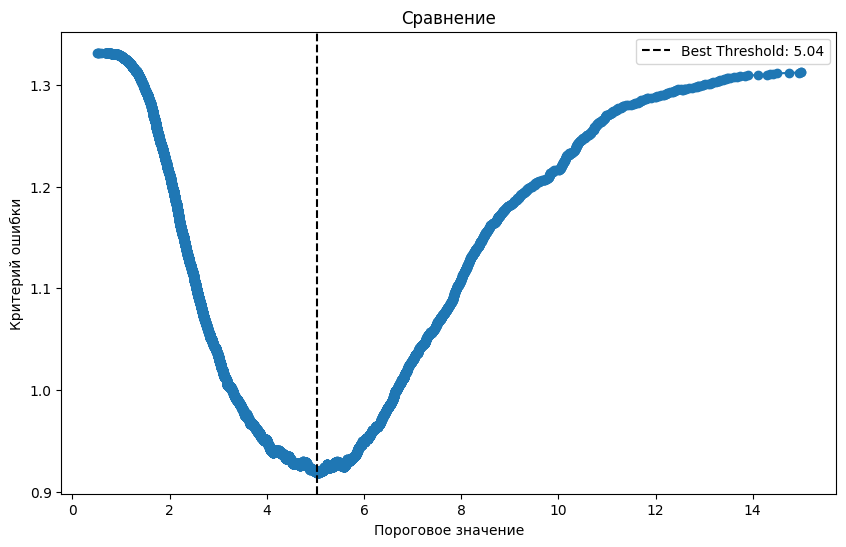

In [10]:
feature_vector = X["MedInc"].values
thresholds, criteria, best_thr, best_crit = find_best_split(feature_vector, y, task="regression", feature_type="real")

thresholds = thresholds[:len(criteria)]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, criteria, marker='o')
plt.axvline(x=best_thr, color='black', linestyle='--', label=f'Best Threshold: {best_thr:.2f}')
plt.xlabel('Пороговое значение')
plt.ylabel('Критерий ошибки')
plt.title('Сравнение')
plt.legend()
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [11]:
def find_best_pred(X, y, task="regression", f_type="real"):
    b_feat = None
    b_thr = None
    b_crit = float('inf')
    for feat in X.columns:
        f_vec = X[feat].values
        thrs, crits, thr, crit = find_best_split(
            f_vec, y, task=task, feature_type=f_type
        )
        if crit < b_crit:
            b_crit = crit
            b_thr = thr
            b_feat = feat
    return b_feat, b_thr, b_crit

b_feat, b_thr, b_crit = find_best_pred(X, y, task="regression", f_type="real")

print("Лучший предикат:", b_feat)

Лучший предикат: MedInc


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [12]:
import numpy as np
from typing import Union, List, Tuple, Dict
from collections import Counter

class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        self._feature_importances = np.zeros(len(feature_types))
        
    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        depth: int = 0
    ) -> None:
        
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return
        
        if self._max_depth is not None and depth >= self._max_depth:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        
        if sub_X.shape[0] < self._min_samples_split:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        
        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                feature_vector = sub_X[:, feature]

            _, _, threshold, gini = self.find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini < gini_best:
                feature_best = feature
                gini_best = gini

                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold_best
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold_best
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        self._feature_importances[feature_best] += gini_best

        node["type"] = "nonterminal"
        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]
        
        if self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[node["feature_split"]] == "categorical":
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError("Unknown feature type")

    def find_best_split(self, feature_vector: np.ndarray, target_vector: np.ndarray, task: str, feature_type: str) -> Tuple[int, float, float, float]:
        if feature_type == "real":
            sorted_idx = np.argsort(feature_vector)
            feature_vector = feature_vector[sorted_idx]
            target_vector = target_vector[sorted_idx]

            thresholds = (feature_vector[:-1] + feature_vector[1:]) / 2
            unique_thresholds = np.unique(thresholds)

            best_criterion = float('inf')
            best_threshold = None

            for thr in unique_thresholds:
                left_mask = feature_vector <= thr
                right_mask = feature_vector > thr

                y_left = target_vector[left_mask]
                y_right = target_vector[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gini_left = 1 - np.sum((np.bincount(y_left, minlength=2) / len(y_left)) ** 2)
                gini_right = 1 - np.sum((np.bincount(y_right, minlength=2) / len(y_right)) ** 2)
                criterion = (len(y_left) * gini_left + len(y_right) * gini_right) / len(target_vector)

                if criterion < best_criterion:
                    best_criterion = criterion
                    best_threshold = thr

            return None, None, best_threshold, best_criterion

        elif feature_type == "categorical":
            unique_values = np.unique(feature_vector)
            best_criterion = float('inf')
            best_threshold = None

            for val in unique_values:
                left_mask = feature_vector == val
                right_mask = feature_vector != val

                y_left = target_vector[left_mask]
                y_right = target_vector[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gini_left = 1 - np.sum((np.bincount(y_left, minlength=2) / len(y_left)) ** 2)
                gini_right = 1 - np.sum((np.bincount(y_right, minlength=2) / len(y_right)) ** 2)
                criterion = (len(y_left) * gini_left + len(y_right) * gini_right) / len(target_vector)

                if criterion < best_criterion:
                    best_criterion = criterion
                    best_threshold = val

            return None, None, best_threshold, best_criterion

    def handle_missing_values(self, X: np.ndarray) -> np.ndarray:
        for feature in range(X.shape[1]):
            if self._feature_types[feature] == "real":
                mean_value = np.nanmean(X[:, feature])
                X[np.isnan(X[:, feature]), feature] = mean_value
            elif self._feature_types[feature] == "categorical":
                mode_value = Counter(X[~np.isnan(X[:, feature]), feature]).most_common(1)[0][0]
                X[np.isnan(X[:, feature]), feature] = mode_value
        return X
    
    def get_feature_importances(self) -> np.ndarray:
        return self._feature_importances / np.sum(self._feature_importances)

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        X = self.handle_missing_values(X)
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

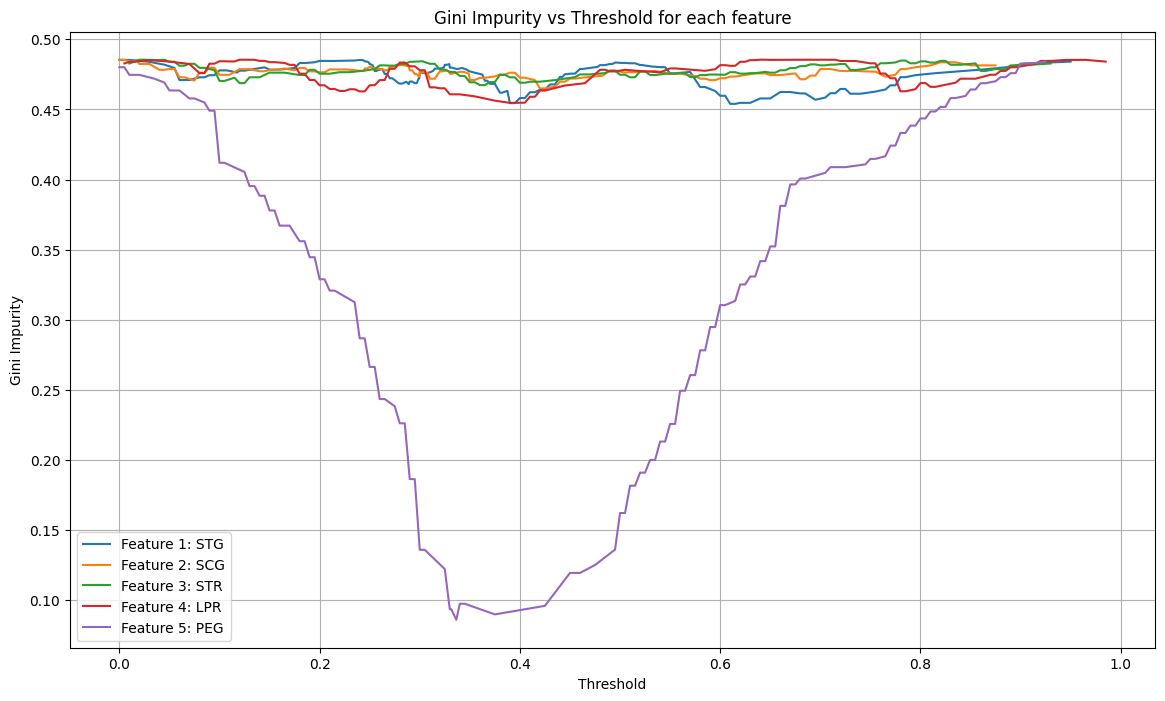

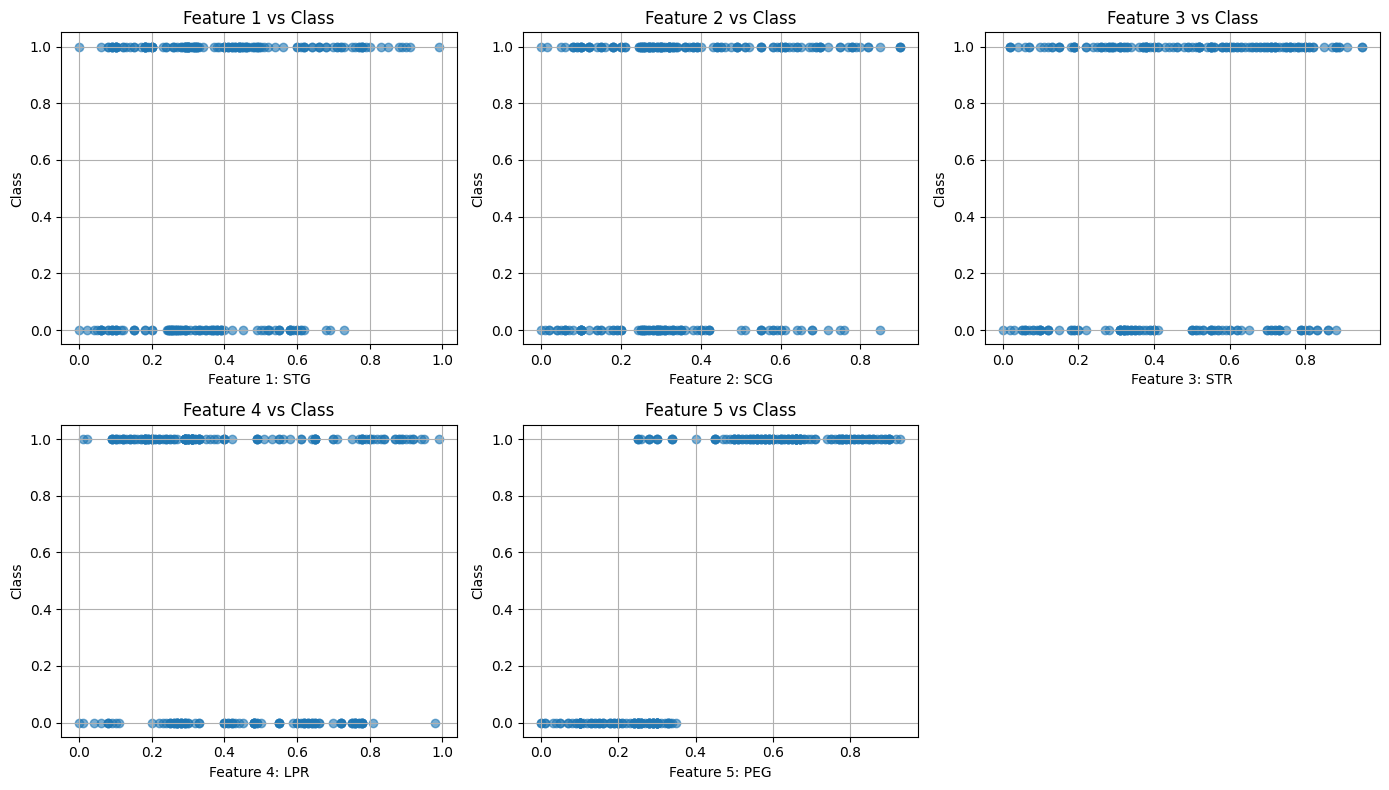

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple

# Загрузка данных
data = pd.read_csv('students.csv')


data = data.drop(columns=['Unnamed: 0'])

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

def best_split(
    f_vec: Union[np.ndarray, pd.DataFrame], 
    t_vec: Union[np.ndarray, pd.Series],
    task: str = "classification",
    f_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    if f_type == "real":
        sorted_idx = np.argsort(f_vec)
        f_vec, t_vec = f_vec[sorted_idx], t_vec[sorted_idx]

        thresholds = (f_vec[:-1] + f_vec[1:]) / 2
        uniq_th = np.unique(thresholds)

        best_crit = float('inf') if task == "regression" else float('-inf')
        best_thr = None
        crit_list = []

        for thr in uniq_th:
            l_mask, r_mask = f_vec <= thr, f_vec > thr
            y_left, y_right = t_vec[l_mask], t_vec[r_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            if task == "classification":
                gini_left = 1 - np.sum((np.bincount(y_left, minlength=2) / len(y_left)) ** 2)
                gini_right = 1 - np.sum((np.bincount(y_right, minlength=2) / len(y_right)) ** 2)
                crit = (len(y_left) * gini_left + len(y_right) * gini_right) / len(t_vec)
            else:
                var_left, var_right = np.var(y_left), np.var(y_right)
                crit = (len(y_left) * var_left + len(y_right) * var_right) / len(t_vec)

            crit_list.append(crit)
            if task == "regression" and crit < best_crit:
                best_crit, best_thr = crit, thr
            elif task == "classification" and crit > best_crit:
                best_crit, best_thr = crit, thr

        return uniq_th, np.array(crit_list), best_thr, best_crit

    elif f_type == "categorical":
        uniq_vals = np.unique(f_vec)
        best_crit = float('inf') if task == "regression" else float('-inf')
        best_thr = None
        crit_list = []

        for val in uniq_vals:
            l_mask, r_mask = f_vec == val, f_vec != val
            y_left, y_right = t_vec[l_mask], t_vec[r_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            if task == "classification":
                gini_left = 1 - np.sum((np.bincount(y_left, minlength=2) / len(y_left)) ** 2)
                gini_right = 1 - np.sum((np.bincount(y_right, minlength=2) / len(y_right)) ** 2)
                crit = (len(y_left) * gini_left + len(y_right) * gini_right) / len(t_vec)
            else:
                var_left, var_right = np.var(y_left), np.var(y_right)
                crit = (len(y_left) * var_left + len(y_right) * var_right) / len(t_vec)

            crit_list.append(crit)
            if task == "regression" and crit < best_crit:
                best_crit, best_thr = crit, val
            elif task == "classification" and crit > best_crit:
                best_crit, best_thr = crit, val

        return uniq_vals, np.array(crit_list), best_thr, best_crit

def plot_gini(X, y):
    plt.figure(figsize=(14, 8))
    
    for i, col in enumerate(X.columns):
        thr, crit, _, _ = best_split(X[col].values, y.values, task="classification", f_type="real")
        if len(thr) > len(crit):
            thr = thr[:len(crit)]
        plt.plot(thr, crit, label=f'Feature {i+1}: {col}')
    plt.xlabel('Threshold')
    plt.ylabel('Gini Impurity')
    plt.title('Gini Impurity vs Threshold for each feature')
    plt.legend()
    plt.grid(True)
    plt.show()
def plot_scatter(X, y):
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(X.columns):
        plt.subplot(2, 3, i+1)
        plt.scatter(X[col], y, alpha=0.6)
        plt.xlabel(f'Feature {i+1}: {col}')
        plt.ylabel('Class')
        plt.title(f'Feature {i+1} vs Class')
        plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_gini(X, y)
plot_scatter(X, y)


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Для разделения выборки на два поддерева лучше всего использовать признак PEG (фиолетовая кривая), так как он показывает самое большое снижение хаотичности. Это подтверждается и визуально: на диаграммах рассеяния PEG четко разделяет классы. У "хороших" признаков кривая Джини имеет форму буквы "V", что указывает на резкое снижение критерия, а у слабых признаков кривая почти плоская, что говорит о слабом разделении

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [14]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
mushroom_data = pd.read_csv('agaricus-lepiota.data')
label_encoders = {}
for column in mushroom_data.columns:
    le = LabelEncoder()
    mushroom_data[column] = le.fit_transform(mushroom_data[column])
    label_encoders[column] = le
X_mushroom = mushroom_data.iloc[:, 1:]
y_mushroom = mushroom_data.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_mushroom, y_mushroom, test_size=0.5, random_state=42)
feature_types = ['categorical'] * X_train.shape[1]
tree = DecisionTree(feature_types=feature_types, min_samples_split=2, min_samples_leaf=1)
tree.fit(X_train.values, y_train.values)
y_pred = tree.predict(X_test.values)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')


Accuracy: 1.000


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [15]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [16]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

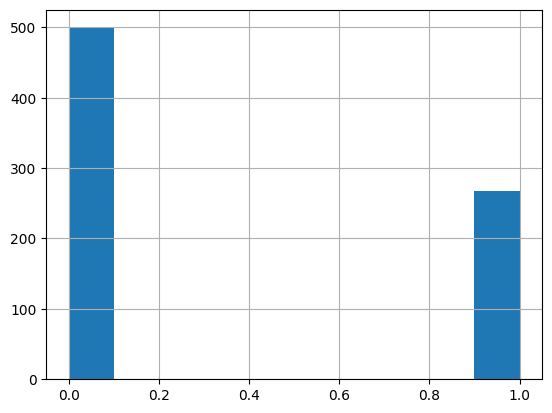

In [17]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [18]:
from sklearn.model_selection import train_test_split

X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print(len(X_train_train), len(X_val), len(X_test))

375 162 231


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
max_depth_values = [1, 3, 5, 7, 10, 15]
min_samples_leaf_values = [1, 2, 3, 5, 7, 15]

best_f1_score = 0
best_params = {'max_depth': None, 'min_samples_leaf': 1}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        tree.fit(X_train_train, y_train_train)
        y_val_pred = tree.predict(X_val)
        current_f1_score = f1_score(y_val, y_val_pred)
        
        if current_f1_score > best_f1_score:
            best_f1_score = current_f1_score
            best_params['max_depth'] = max_depth
            best_params['min_samples_leaf'] = min_samples_leaf
final_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, random_state=42)
final_tree.fit(X_train, y_train)
y_test_pred = final_tree.predict(X_test)
y_test_prob = final_tree.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
auc_roc = roc_auc_score(y_test, y_test_prob)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'AUC-ROC: {auc_roc:.3f}')


Accuracy: 0.766
Precision: 0.800
Recall: 0.444
AUC-ROC: 0.818


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [24]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
rf_clf.fit(X_train, y_train)
y_rf_pred = rf_clf.predict(X_test)
y_rf_prob = rf_clf.predict_proba(X_test)[:, 1]
print(f'Accuracy: {accuracy_score(y_test, y_rf_pred)}')
print(f'Precision: {precision_score(y_test, y_rf_pred)}')
print(f'Recall: {recall_score(y_test, y_rf_pred)}')
print(f'AUC-ROC: {roc_auc_score(y_test, y_rf_prob)}')


Accuracy: 0.7532467532467533
Precision: 0.7068965517241379
Recall: 0.5061728395061729
AUC-ROC: 0.8293827160493827


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [27]:
best_f1_score = 0
best_params_rf = {'max_depth': None, 'min_samples_split': 2}
final_rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
final_rf_clf.fit(X_train, y_train)

y_rf_pred = final_rf_clf.predict(X_test)
y_rf_prob = final_rf_clf.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_rf_pred)
rf_prec = precision_score(y_test, y_rf_pred)
rf_rec = recall_score(y_test, y_rf_pred)
rf_auc = roc_auc_score(y_test, y_rf_prob)

print(f'Best params: {best_params_rf}')
print(f'Best F1 score from CV: {best_f1_score:.3f}')
print(f'Accuracy: {rf_acc:.3f}')
print(f'Precision: {rf_prec:.3f}')
print(f'Recall: {rf_rec:.3f}')
print(f'AUC-ROC: {rf_auc:.3f}')

Best params: {'max_depth': None, 'min_samples_split': 2}
Best F1 score from CV: 0.000
Accuracy: 0.736
Precision: 0.661
Recall: 0.506
AUC-ROC: 0.823


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

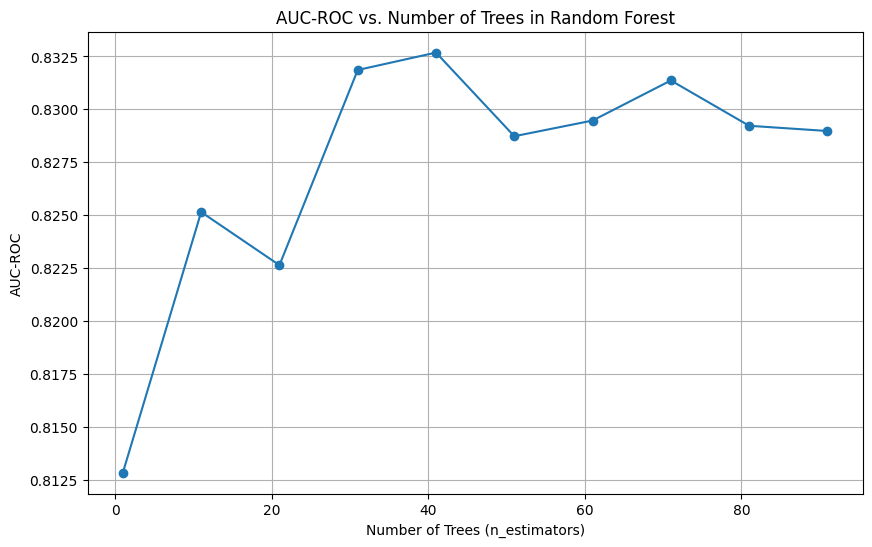

In [25]:
n_estimators_range = range(1, 101, 10)
auc_scores = []
for n in n_estimators_range:
    rf_clf = RandomForestClassifier(
        n_estimators=n,
        max_depth=best_params['max_depth'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )
    rf_clf.fit(X_train, y_train)
    y_rf_prob = rf_clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_rf_prob)
    auc_scores.append(auc)
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores, marker='o')
plt.title('AUC-ROC vs. Количество деревьев в Случайном Лесу')
plt.xlabel('Количество деревьев (n_estimators)')
plt.ylabel('AUC-ROC')
plt.grid(True)
plt.show()

Когда количество деревьев увеличивается с 1 до 20, заметно значительное улучшение AUC-ROC. Это показывает, что добавление новых деревьев положительно влияет на качество модели. Однако после достижения 20 деревьев рост AUC-ROC замедляется, и график начинает колебаться. Это свидетельствует о том, что после определенного количества деревьев добавление новых не приводит к значительному улучшению качества модели. На графике также видно, что максимальное значение AUC-ROC достигается примерно при 30 деревьях. Таким образом, можно предположить, что для данной задачи оптимальное количество деревьев находится в диапазоне от 30 до 40.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

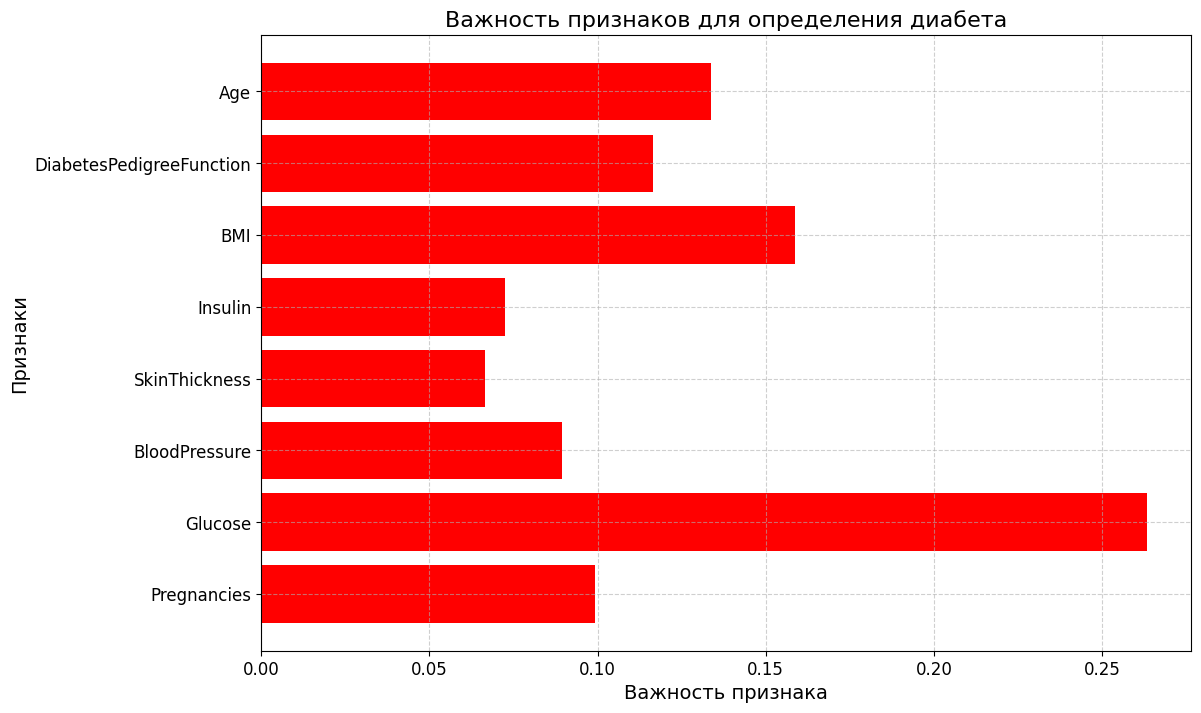

Самый важный признак: Glucose


In [29]:
best_params_rf = {'max_depth': None, 'min_samples_split': 2}
final_rf_clf = RandomForestClassifier(
    n_estimators=50,
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    random_state=42
)
final_rf_clf.fit(X_train, y_train)

feature_importances = final_rf_clf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(12, 8))
plt.barh(feature_names, feature_importances, color='red')
plt.xlabel('Важность признака', fontsize=14)
plt.ylabel('Признаки', fontsize=14)
plt.title('Важность признаков для определения диабета', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
most_important_feature = feature_names[feature_importances.argmax()]
print(f'Самый важный признак: {most_important_feature}')